# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

## Постановка задачи

#### Задача достижимости

$RPQ = \{(v_i, v_j)|\exists \pi: v_i \pi v_j \in L; v_i, v_j \in V\}$

В ходе данной работы будут исследованы следующие задачи достижимости:
1. Достижимость между всеми парами вершин.
2. Достижимость для всего множества заданных вершин.
3. Достижимость для каждой из заданного множества стартовых вершин.

#### Цель работы 

Целью данной работы является анализ производительности алгоритма решения задачи достижимости для вышеперечисленных пунктов.

Для достижения поставленной цели необходимо в ходе исследования ответить на следующие вопросы:
1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
3. На сколько решение третьей задачи медленнее решения второй при одинаковых начальных условиях?    

## Описание исследуемых решений

В ходе исследования будут применены результаты предыдущих работ, которые можно найти в `project.regular_path_query`. А именно:
1. Алгоритм выполнения регулярных запросов к графам через построение пересечения двух автоматов, один из которых построен на основе графа, а другой на основе регулярного выражения, с последующим построением транзитивного замыкания. Представлен функцией `tensor_rpq`.
2. Алгоритм обхода графа (автомата) в ширину (BFS). Представлен функцией `bfs_rpq`.

## Описание набора данных для экспериментов

#### Графы

Были использованы следующие графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html):
1. Travel – 131 вершина, 277 ребер. 
2. Pizza – 671 вершина, 1980 ребер. 
3. Core – 1323 вершин, 2752 ребра. 

Данный выбор обусловлен желанием рассмотреть результаты работы алгоритмов на графах с достаточно отлисающимся друг от друга количеством вершин и ребер. При этом получение результатов для графов с бóльшим количеством вершин, чем у core, занимает слишком много времени на имеющемся оборудовании. Кроме того, все вышеперечисленные варианты графов содержат более, чем два варианта меток, что позволит исследовать более сложные регулярные выражения.

#### Регулярные запросы

Для изучения результатов работы алгоритмов были использованы следующие регулярные запросы для самых распространенных меток на ребрах:
1. `(l1 | l2)* l3`
2. `(l3 | l4)+ l1*`
3. `l1 l2 l3 (l4|l1)*`
4. `(l1)* | (l2 l3)`

## Описание эксперимента

### Оборудование

- Процессор: Intel Core i5-12500H, 2.5 ГГц 
- Объем ОЗУ: 16ГБ
- ОС: Ubuntu 23.04
- Версия python: 3.11.4

### Проведение замеров: 

1. Для ответа на первый вопрос о том, какое представление разреженных матриц и векторов лучше подходит для решаемых задач, были проведены замеры на следующих представлениях разреженных матриц при фиксированном наборе стартовых вершин: 
    - [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix)
    - [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)
    - [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)
    - [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)


2. Для ответа на второй вопрос о том, при каких размерах стартового множества становится выгоднее решать задачу для всех пар и выбирать нужные, при проведении эксперимента изменялось стартовое множество вершин, в то время как представление матрицы было зафиксировано.

3. Для ответа на третий вопрос о разнице во времени решения второй и третьей задачи достижимости были проведены замеры на графах с различными наборами стартовых вершин.

Замеры времени производятся в секундах. Каждый замер проводился 10 раз и выводилось его среднее значение со стандартным отклонением. 

### Ход работы

Порядок выполнения: 
1. Необходимые импорты
2. Отображение диаграммы
3. Построение регекса на основе самых часто встречающихся меток
4. Построение достижимости для всех пар вершин
5. Построение достижимости с заданным множеством стартовых вершин
6. Построение достижимости вершин для каждой из заданного множества стартовых
7. Выбор алгоритма для дальнейшего исследования
    - Тензорный
    - Обход в ширину
8. Исследование лучшего представления разреженных матриц и векторов для каждой из решаемых задач (вопрос 1)
9. Выявление размера стартового множества, для которого выгоднее решать задачу для всех пар и выбирать нужные (вопрос 2).
10. Сравнение производительности второй и третьей задачи достижимости при одинаковых начальных условиях (Вопрос 3).

После каждого из трех последних пунктов можно прочитать выводы (ответы на вопросы). 

#### Необходимые импорты

In [104]:
import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import cfpq_data
from pyformlang.regular_expression import Regex
from scipy import stats
from scipy.sparse import dok_matrix, lil_matrix, csc_matrix, csr_matrix

from project.regular_path_query import tensor_rpq, bfs_rpq

#### Отображение диаграммы

In [112]:
def display_diagram(percent_of_sources, graph, matrix_time, matrix_deviation, matrix_type):
    index = np.arange(0, 4, 1)
    bw = 0.2
    plt.title(graph + " " + percent_of_sources + "% of start nodes", fontsize=16)
    colors = ["yellow", "purple", "blue", "green"]
    for cnt, matrix in enumerate(matrix_type):
        plt.bar(index + bw * (cnt + 1), matrix_time[matrix.__name__], bw,
            yerr=matrix_deviation[matrix.__name__],
            error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[cnt], label=matrix.__name__)

    plt.xticks(index + 3 * bw, ["(l1 | l2)* l3", "(l3 | l4)+ l1*", "l1 l2 l3 (l4|l1)*", "(l1)* | (l0 l3)"])
    plt.legend(loc=1)
    plt.show()

#### Построение регекса на основе самых часто встречающихся меток

In [106]:
def build_most_common_labels(most_common_labels):
    return [
        "(" + str(most_common_labels[0][0]) + "|" + str(most_common_labels[1][0]) + ")*" + str(
            most_common_labels[2][0]),

        "(" + str(most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")|(" + str(
            most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")*" + str(
            most_common_labels[0][0]) + "*",

        str(most_common_labels[0][0]) + " " + str(most_common_labels[1][0]) + " " + str(
            most_common_labels[2][0]) + "(" + str(most_common_labels[3][0]) + "|" + str(
            most_common_labels[0][0]) + ")*",

        "(" + str(most_common_labels[0][0]) + ")*|(" + str(most_common_labels[1][0]) + " " 
        + str(most_common_labels[2][0]) + ")",
    ]

#### Построение достижимости для всех пар вершин

In [107]:
number_of_launches = 10
matrices = [lil_matrix, dok_matrix, csr_matrix, csc_matrix]
dataset_graph = ["travel","pizza", "core"]

def rpq_all_pairs(type_rpq, matrices=matrices):
    for graph_name in dataset_graph:

        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
        
        regexes = build_most_common_labels(most_common_labels)
           
        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        
        for regex in regexes:
            regex = Regex(regex)

            for matrix in matrices:
                times = []
                
                for _ in range(number_of_launches):
                    start_time = time.time()
                    
                    type_rpq(graph=graph, regex=regex, start_nodes=None, final_nodes=None, for_each_node=True, matrix_type=matrix)
                    
                    final_time = time.time() - start_time
                    times.append(final_time)

                avg_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[matrix.__name__].append(avg_time)
                matrix_deviation[matrix.__name__].append(deviation)

        display_diagram("100", graph_name, matrix_time, matrix_deviation, matrices)

#### Построение достижимости с заданным множеством стартовых вершин

In [108]:
def rpq_start_vertexes(start_states_percent=30, matrices=matrices, type_rpq=tensor_rpq):
    for graph_name in dataset_graph:
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
        regexes = build_most_common_labels(most_common_labels)
        start_nodes = cfpq_data.generate_multiple_source_percent(graph, start_states_percent, seed=123)

        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        
        for regex in regexes:
            regex = Regex(regex)

            for matrix in matrices:
                times = []
                
                for _ in range(number_of_launches):
                    start = time.time()

                    type_rpq(graph=graph, regex=regex, start_nodes=start_nodes, final_nodes=None, for_each_node=False, matrix_type=matrix)

                    stop = time.time() - start
                    times.append(stop)

                avg_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[matrix.__name__].append(avg_time)
                matrix_deviation[matrix.__name__].append(deviation)
                
        display_diagram(str(int(start_states_percent)), graph_name, matrix_time, matrix_deviation, matrices)

#### Построение достижимости вершин для каждой из заданного множества стартовых

In [125]:
def rpq_for_each_start(start_states_percent=30, matrices=matrices, type_rpq=tensor_rpq):
    for graph_name in dataset_graph:
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
        source_vertices = cfpq_data.generate_multiple_source_percent(graph, start_states_percent, seed=123)

        regexes = build_most_common_labels(most_common_labels)

        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}

        for regex in regexes:
            request = Regex(regex)

            for matrix in matrices:
                times = []

                for _ in range(number_of_launches):
                    start_time = time.time()
                    
                    type_rpq(graph=graph, regex=request, start_nodes=source_vertices, final_nodes=None,
                               for_each_node=True,
                               matrix_type=matrix)
                    
                    final_time = time.time() - start_time
                    times.append(final_time)

                avg_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[matrix.__name__].append(avg_time)
                matrix_deviation[matrix.__name__].append(deviation)

        display_diagram(graph_name, str(int(start_states_percent)), matrix_time, matrix_deviation, matrices)

## Выбор алгоритма для дальнейшего исследования

#### Алгоритм тензорного произведения

[2023-10-10 18:10:09]>INFO>Found graph with name='travel'
[2023-10-10 18:10:10]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:10:10]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:10:10]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:10:10]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436eea1d50> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')


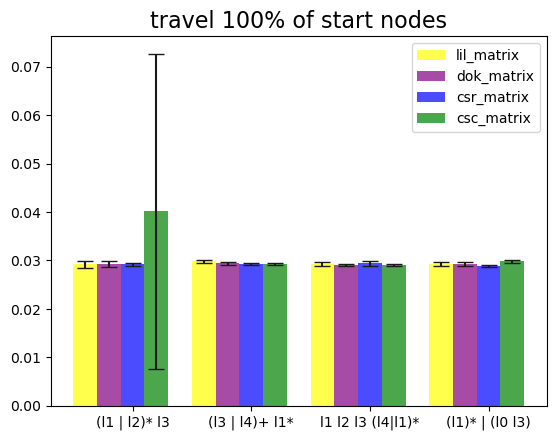

[2023-10-10 18:10:14]>INFO>Found graph with name='pizza'
[2023-10-10 18:10:15]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:10:15]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:10:15]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:10:15]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8acf690> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')


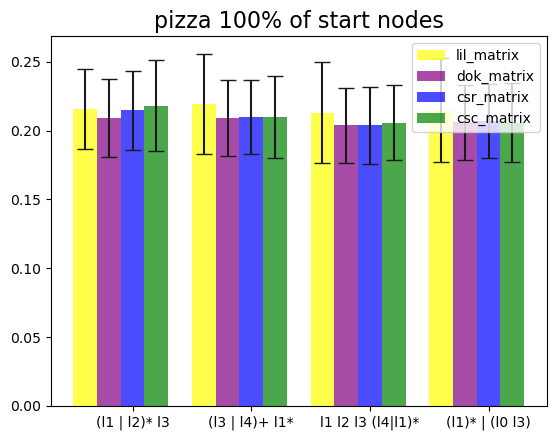

[2023-10-10 18:10:48]>INFO>Found graph with name='core'
[2023-10-10 18:10:48]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:10:48]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:10:48]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:10:48]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436dfbc350> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')


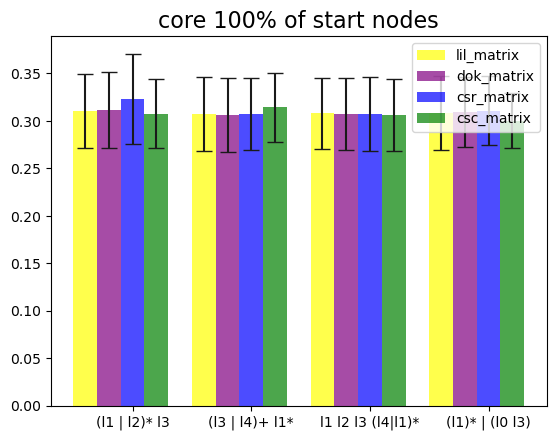

In [115]:
rpq_all_pairs(tensor_rpq)

#### Алгоритм обхода в ширину

[2023-10-09 21:59:22]>INFO>Found graph with name='travel'
[2023-10-09 21:59:27]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-09 21:59:27]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-09 21:59:27]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-09 21:59:27]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7eff96751e50> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
/usr/lib/python3/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/lib/python3/dist-

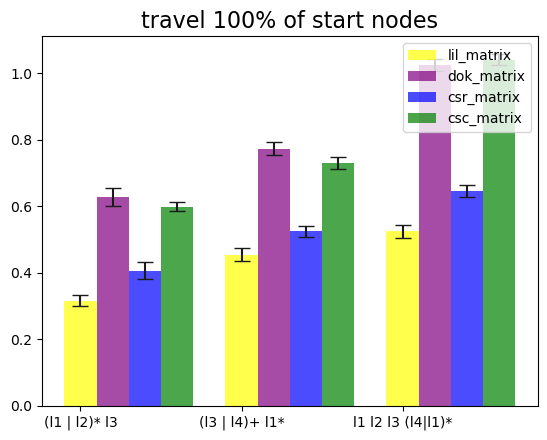

[2023-10-09 22:00:44]>INFO>Found graph with name='pizza'
[2023-10-09 22:00:49]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-09 22:00:49]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-09 22:00:49]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-09 22:00:49]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7eff8fdfe810> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')


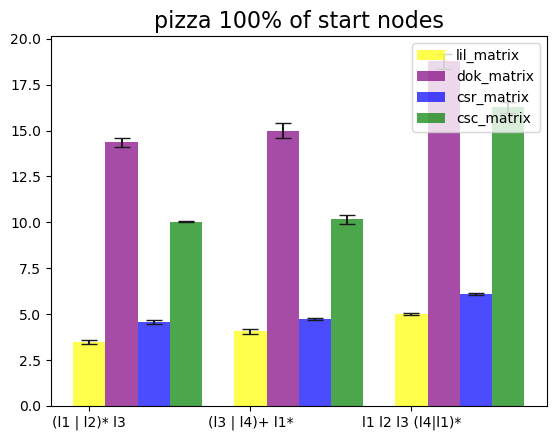

[2023-10-09 22:19:34]>INFO>Found graph with name='core'
[2023-10-09 22:19:39]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-09 22:19:39]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-09 22:19:39]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-09 22:19:39]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7eff8f0a87d0> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')


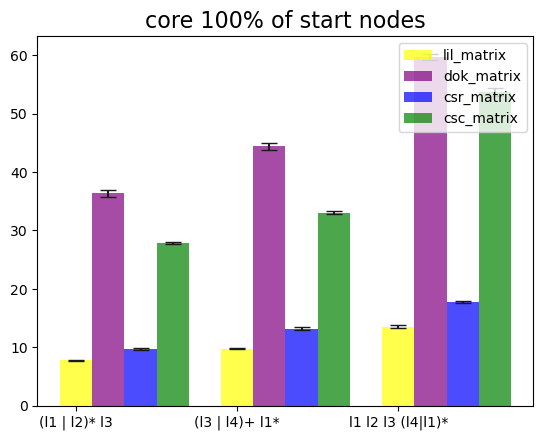

In [ ]:
rpq_all_pairs(bfs_rpq)

Результаты эксперимента показали, что задача достижимости между всеми парами вершин решается быстрее при помощи алгоритма, основанного на применении `тензорного произведения`. Поэтому для ответа на вопрос 1, который требует рассмотрения всех четырех представлений матриц, будет использоваться алгоритм тензорного произведения, иначе получение результата эксперимента занимает значительное время (задача обработки графа core для всех пар вершин на оговоренном оборудовании занимает около 1 часа 10 минут). В общем случае используются оба алгоритма, если не оговерено иное.

## Исследование лучшего представления разреженных матриц и векторов для каждой из решаемых задач (вопрос 1)

[2023-10-10 18:08:21]>INFO>Found graph with name='travel'
[2023-10-10 18:08:21]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:08:21]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:08:21]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:08:21]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a859d410> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')


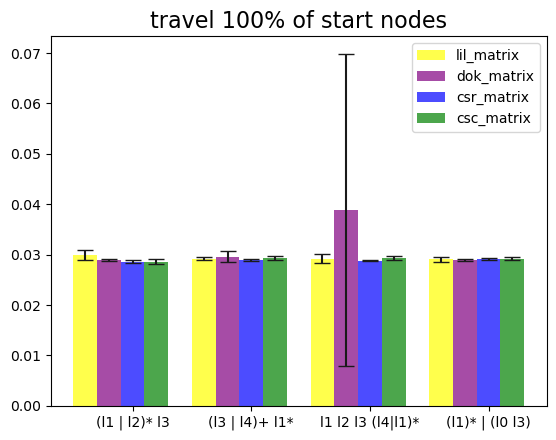

[2023-10-10 18:08:26]>INFO>Found graph with name='pizza'
[2023-10-10 18:08:26]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:08:26]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:08:26]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:08:26]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9c11a50> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')


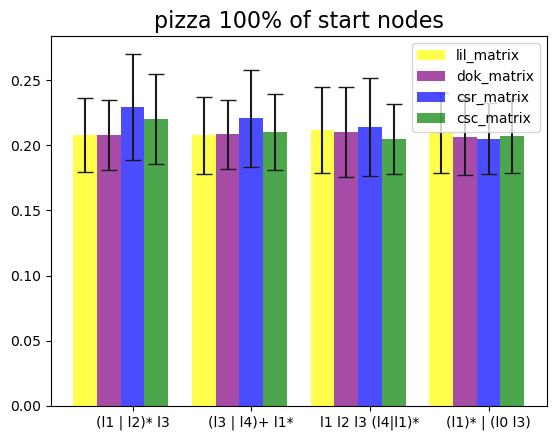

[2023-10-10 18:09:00]>INFO>Found graph with name='core'
[2023-10-10 18:09:00]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:09:00]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:09:00]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:09:00]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f4354ade290> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')


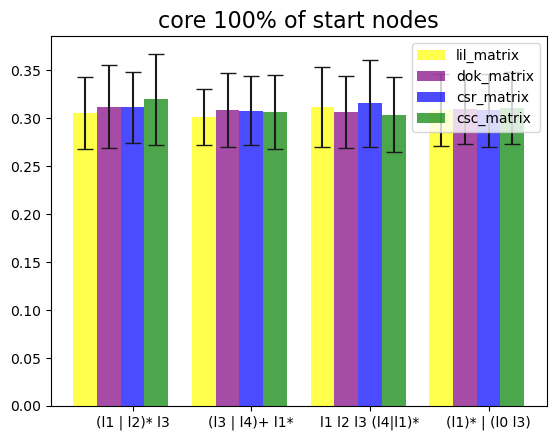

In [114]:
rpq_all_pairs(type_rpq=tensor_rpq)

[2023-10-10 18:12:21]>INFO>Found graph with name='travel'
[2023-10-10 18:12:21]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:12:21]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:12:21]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:12:21]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a938b190> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:12:21]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a938b190> for multiple-source evaluation


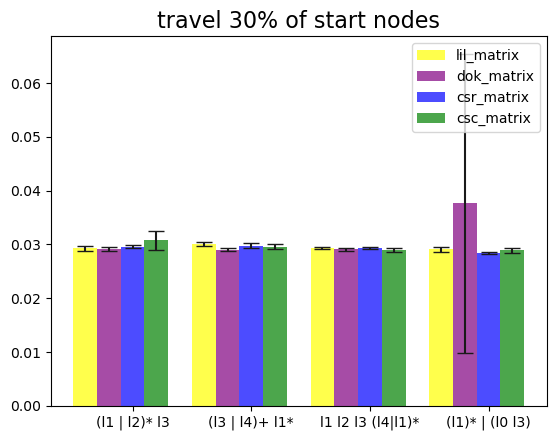

[2023-10-10 18:12:26]>INFO>Found graph with name='pizza'
[2023-10-10 18:12:26]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:12:26]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:12:26]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:12:26]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8acfcd0> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:12:26]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8acfcd0> for multiple-source evaluation


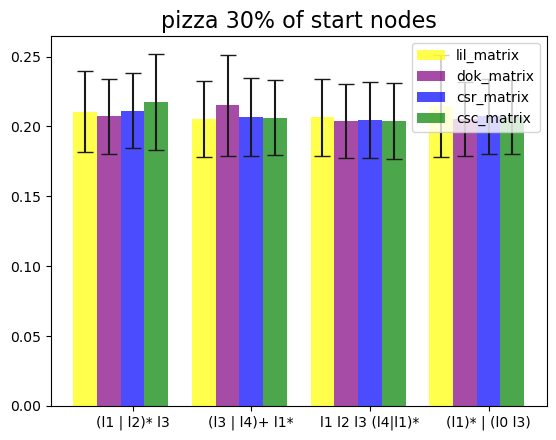

[2023-10-10 18:12:59]>INFO>Found graph with name='core'
[2023-10-10 18:12:59]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:12:59]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:12:59]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:12:59]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f4363cb6590> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:12:59]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f4363cb6590> for multiple-source evaluation


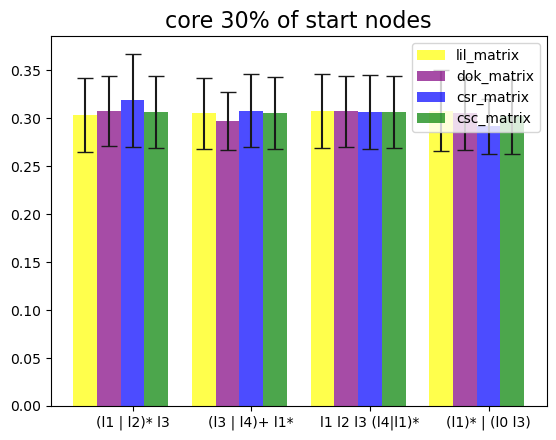

In [116]:
rpq_start_vertexes(type_rpq=tensor_rpq)

[2023-10-10 18:13:53]>INFO>Found graph with name='travel'
[2023-10-10 18:13:53]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:13:53]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:13:53]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2023-10-10 18:13:53]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ef2f550> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2023-10-10 18:13:53]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ef2f550> for multiple-source evaluation


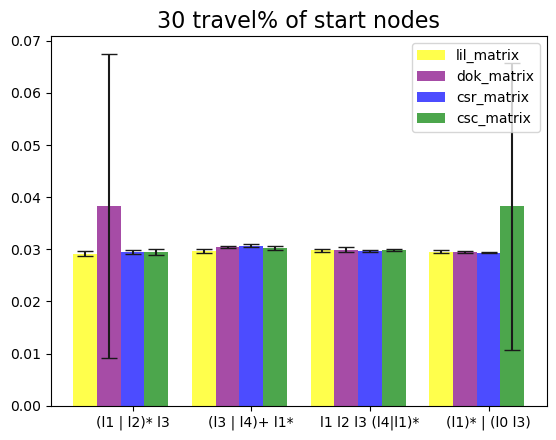

[2023-10-10 18:13:58]>INFO>Found graph with name='pizza'
[2023-10-10 18:13:58]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:13:58]>INFO>Unzip graph name='pizza' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:13:58]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza.tar.gz')
[2023-10-10 18:13:58]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9ce5010> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/pizza/pizza.csv')
[2023-10-10 18:13:58]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9ce5010> for multiple-source evaluation


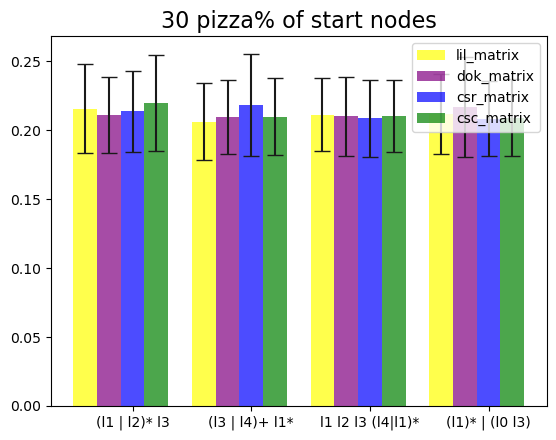

[2023-10-10 18:14:32]>INFO>Found graph with name='core'
[2023-10-10 18:14:32]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:14:32]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:14:32]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:14:32]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a97d8e90> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:14:32]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a97d8e90> for multiple-source evaluation


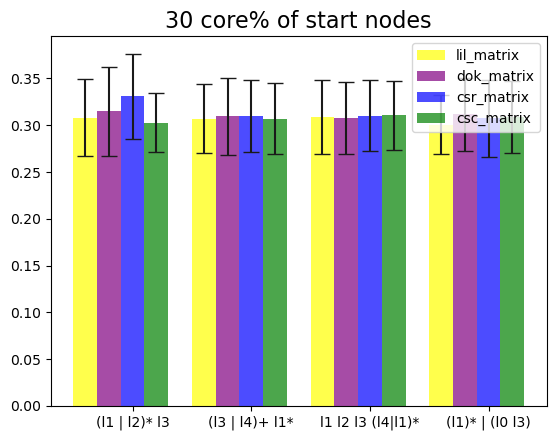

In [117]:
rpq_for_each_start(type_rpq=tensor_rpq)

В ходе проведения замеров, не было выделено существенных преимуществ одного представления над другим. Каждое из четырех представлений могло оказаться наиболее производительным для конкретного случая графа и меток. Однако, можно выделить то, что представление lil_matrix чаще оказывается более производительным, а если проигрывает в производительности, то не сильно отличается от других представлений. Кроме того, стоит упомянуть, что в предыдущем эксперименте по измерению работы алгоритма BFS, lil_matrix показывало наиболее существенный выигрыш по времени для задачи достижимости всех пар вершин.

Итого, проанализировав результаты эксперимента, можно обобщить вывод на все три задачи достижимости. Наиболее предпочтительным представлением для решения задач с помощью тензорного алгоритма будет lil_matrix, которое ни разу не потеряло в производительности, в отличие от других трех представлений.

## Выявление размера стартового множества, для которого выгоднее решать задачу для всех пар и выбирать нужные (вопрос 2).

[2023-10-10 18:15:51]>INFO>Found graph with name='core'
[2023-10-10 18:15:51]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:15:51]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:15:51]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:15:51]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9d84a10> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:15:51]>INFO>Generate set of source vertices of 132 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9d84a10> for multiple-source evaluation
/usr/lib/python3/dist-packages/scipy/sparse/_index.py:137: SparseEfficie

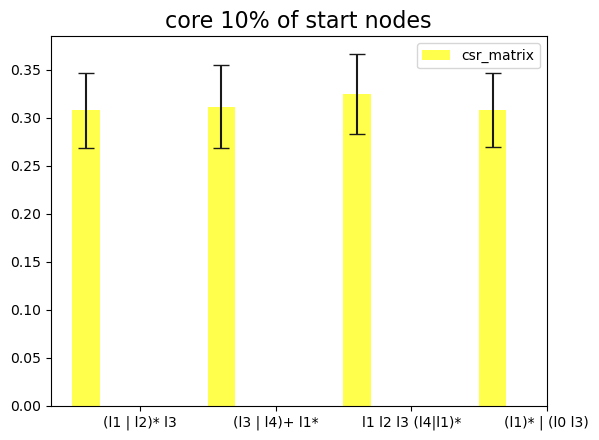

[2023-10-10 18:16:03]>INFO>Found graph with name='core'
[2023-10-10 18:16:03]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:16:03]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:16:03]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:16:03]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9d84a10> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:16:03]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9d84a10> for multiple-source evaluation


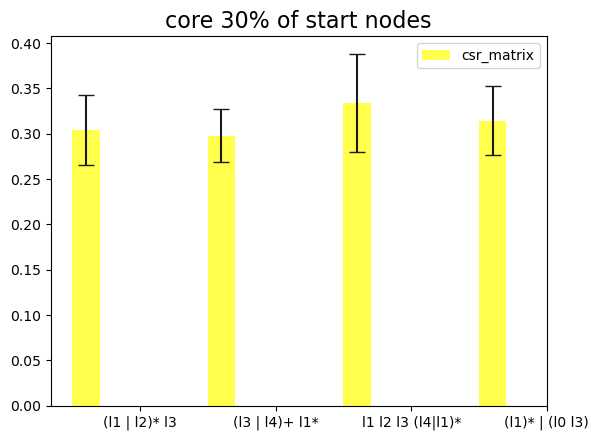

[2023-10-10 18:16:16]>INFO>Found graph with name='core'
[2023-10-10 18:16:16]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:16:16]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:16:16]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:16:16]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8667b10> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:16:16]>INFO>Generate set of source vertices of 661 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8667b10> for multiple-source evaluation


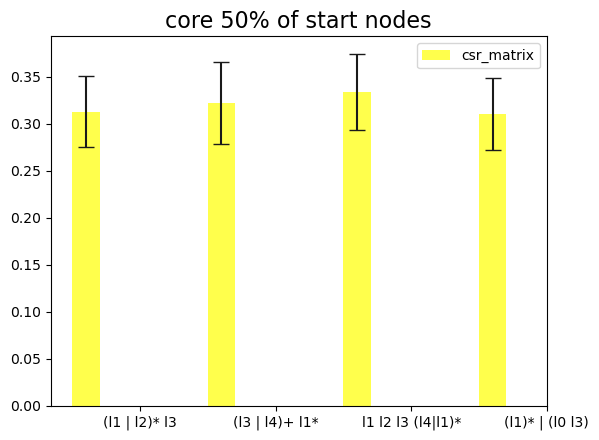

In [118]:
dataset_graph = ["core"]

start_states_percent = [10.0, 30.0, 50.0]
for perc in start_states_percent:
    rpq_start_vertexes(start_states_percent=perc, matrices=[csr_matrix], type_rpq=bfs_rpq)

[2023-10-10 18:17:03]>INFO>Found graph with name='core'
[2023-10-10 18:17:03]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:03]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:03]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:03]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43b2d16910> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:03]>INFO>Generate set of source vertices of 132 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43b2d16910> for multiple-source evaluation


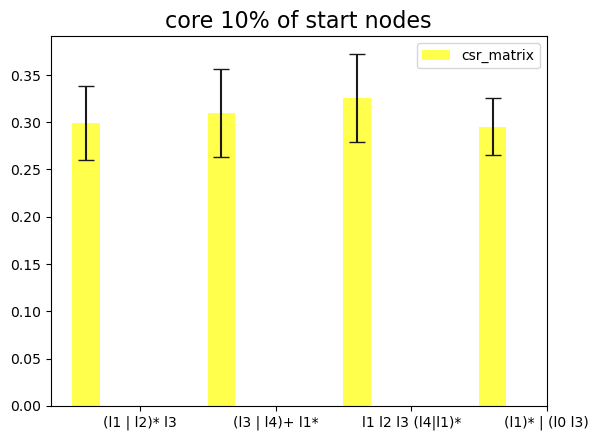

[2023-10-10 18:17:16]>INFO>Found graph with name='core'
[2023-10-10 18:17:16]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:16]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:16]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:16]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a92a9350> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:16]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a92a9350> for multiple-source evaluation


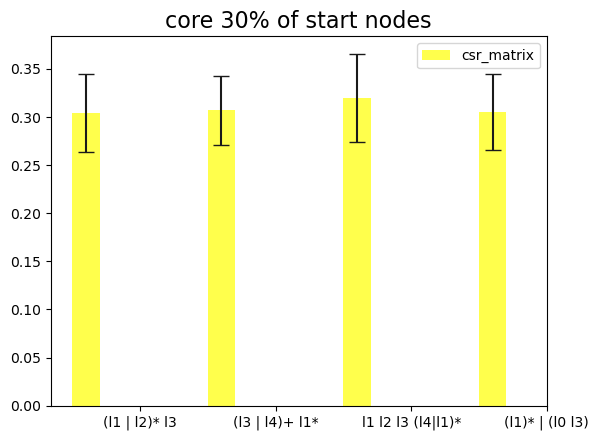

[2023-10-10 18:17:28]>INFO>Found graph with name='core'
[2023-10-10 18:17:28]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:28]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:28]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:17:28]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ceb59d0> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:17:28]>INFO>Generate set of source vertices of 661 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ceb59d0> for multiple-source evaluation


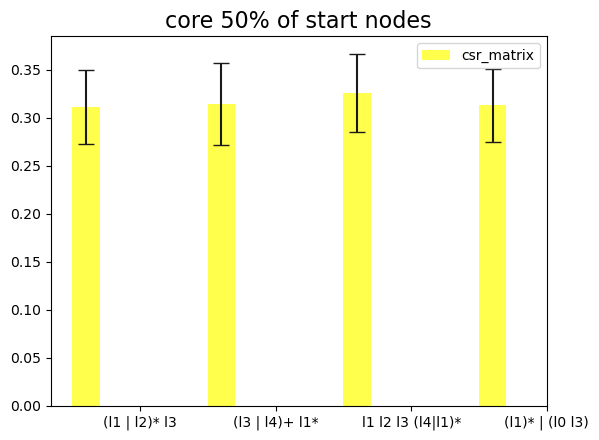

In [119]:
for perc in start_states_percent:
    rpq_start_vertexes(start_states_percent=perc, matrices=[csr_matrix], type_rpq=tensor_rpq)

На графиках можно заметить небольшие уменьшения времени работы с увеличением количества стартовых вершин. Скорее всего, они связаны с погрешностью конкретного запуска и с относительно небольшим размером графа. К сожалению, у автора не получилось дождаться результатов работы алгоритмов на графах больше, чем `core`, чтобы проверить свою гипотезу. Поэтому на основе нескольких запусков алгоритма и представленной информации можно сделать вывод, что в общем случае время работы алгоритмов тем больше, чем больше процент стартовых вершин.

## Сравнение производительности второй и третьей задачи достижимости при одинаковых начальных условиях (Вопрос 3).

Для получения ответа на данный вопрос был использован только алгоритм BFS, так как тензорный алгоритм работает слишком быстро и наглядно увидеть различия в замерах представляется достаточно сложной задачей, поэтому графики получаются неинформативными.

[2023-10-10 19:24:18]>INFO>Found graph with name='core'
[2023-10-10 19:24:18]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:18]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:18]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:18]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a972a450> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:18]>INFO>Generate set of source vertices of 132 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a972a450> for multiple-source evaluation


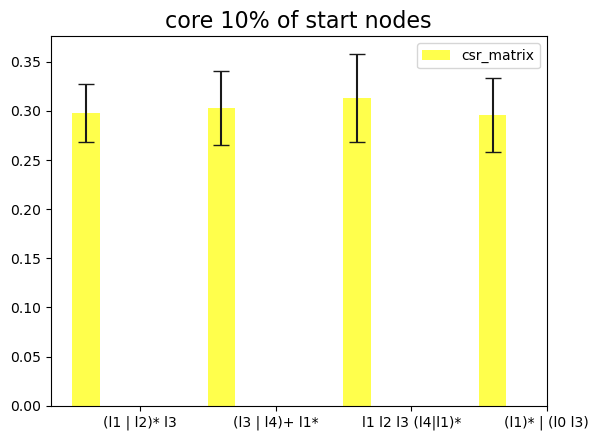

[2023-10-10 19:24:30]>INFO>Found graph with name='core'
[2023-10-10 19:24:30]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:30]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:30]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:30]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9becdd0> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:30]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9becdd0> for multiple-source evaluation


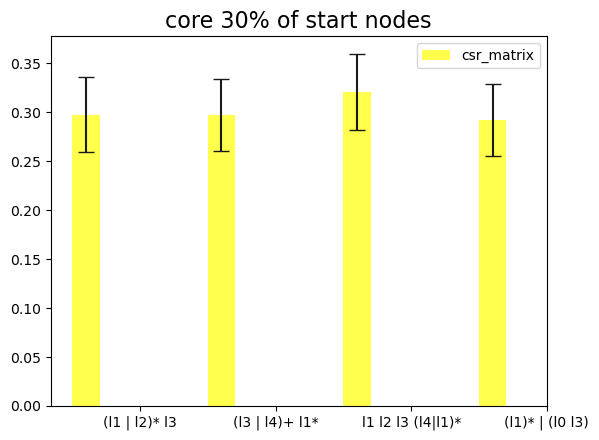

[2023-10-10 19:24:43]>INFO>Found graph with name='core'
[2023-10-10 19:24:43]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:43]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:43]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 19:24:43]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436e0a01d0> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 19:24:43]>INFO>Generate set of source vertices of 661 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436e0a01d0> for multiple-source evaluation


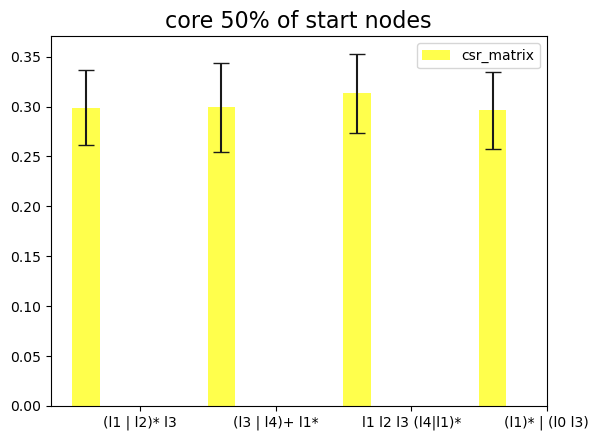

In [130]:
for perc in start_states_percent:
    rpq_start_vertexes(start_states_percent=perc, matrices=[csr_matrix], type_rpq=bfs_rpq)

[2023-10-10 18:29:46]>INFO>Found graph with name='core'
[2023-10-10 18:29:46]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:29:46]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:29:46]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:29:46]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8667290> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:29:46]>INFO>Generate set of source vertices of 132 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a8667290> for multiple-source evaluation
/usr/lib/python3/dist-packages/scipy/sparse/_index.py:103: SparseEfficie

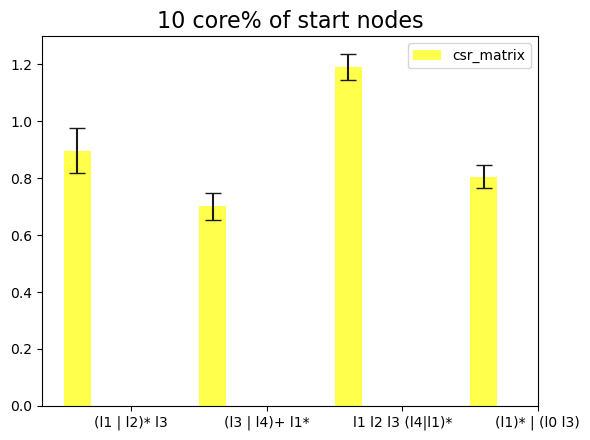

[2023-10-10 18:30:22]>INFO>Found graph with name='core'
[2023-10-10 18:30:22]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:30:22]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:30:22]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:30:22]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ef2f550> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:30:22]>INFO>Generate set of source vertices of 396 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f436ef2f550> for multiple-source evaluation


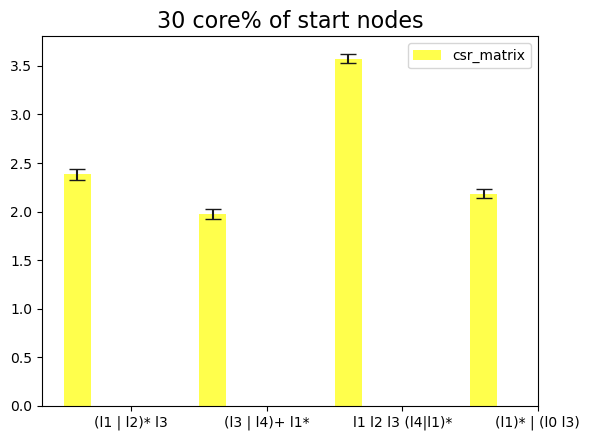

[2023-10-10 18:32:03]>INFO>Found graph with name='core'
[2023-10-10 18:32:04]>INFO>Load archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:32:04]>INFO>Unzip graph name='core' to file graph=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:32:04]>INFO>Remove archive graph_archive=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core.tar.gz')
[2023-10-10 18:32:04]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9408750> from path=PosixPath('/home/sayumiko/.local/lib/python3.11/site-packages/cfpq_data/data/graphs/core/core.csv')
[2023-10-10 18:32:04]>INFO>Generate set of source vertices of 661 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f43a9408750> for multiple-source evaluation


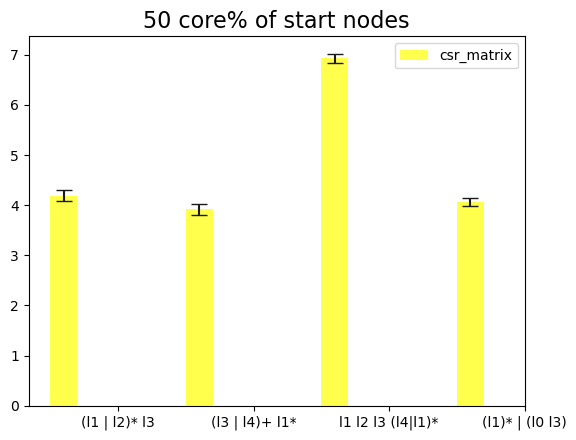

In [129]:
for perc in start_states_percent:
    rpq_for_each_start(start_states_percent=perc, matrices=[csr_matrix], type_rpq=bfs_rpq)

На графиках можно увидеть, что задача `достижимости для каждой из заданного множества стартовых вершин` обрабатывается медленнее, чем задача `достижимости для всего множества заданных вершин`. Скорее всего, это является следствием количества матричных умножений, которых при решении задачи для каждой вершины получается больше.